## Fit transit in a Dataset from a CHEOPSim simulation 

In [1]:
%pylab inline
from pycheops import Dataset, StarProperties
from uncertainties import ufloat
# Temporary(?) fix for problem with coordinate look-up for HD stars in astropy 
from astropy.coordinates.name_resolve import sesame_database
sesame_database.set('simbad');

Populating the interactive namespace from numpy and matplotlib


### Create and instance of the dataset


*Run pycheops.core.setup_config once first to create the configuration file and data cache directory*


```python
>>> from pycheops.core import setup_config
>>> setup_config()
```
There are 3 ways to load a dataset

1. Use a .zip file already downloaded and save in the local data cache directory, e.g., 
```python
>>> dataset = Dataset('CH_PR900048_TG001501_V0000')
```

2. Download an example data set, e.g., 
```python
>>> dataset = Dataset.from_test_data('DP-079', target='HD97658')
```

3. Download the simulated data from CHEOPsim ftp site using the run number, e.g., 
```python
>>> dataset = Dataset.from_simulation(7649, target='HD97658')
```

**N.B.** CHEOPsim output is removed from the FTP server after some time so option 3 may not work for old simulations.

In [2]:
dataset = Dataset('CH_PR900048_TG001501_V0000', target='HD97658')
#dataset=Dataset.from_test_data('DP-079', target='HD97658')
#dataset = Dataset.from_simulation(7649, target='HD97658')
dataset = Dataset('CH_PR900048_TG001501_V0000', target='HD97658')
_ = dataset.get_lightcurve(aperture='OPTIMAL')

Found archive tgzfile /Users/pflm/pycheops_data/CH_PR900048_TG001501_V0000.tgz
 PI name     : CHEOPSim
 OBS ID      : 7649
 Target      : HD97658
 Coordinates : 11:14:33.16 +25:42:37.4
Found archive tgzfile /Users/pflm/pycheops_data/CH_PR900048_TG001501_V0000.tgz
 PI name     : CHEOPSim
 OBS ID      : 7649
 Target      : HD97658
 Coordinates : 11:14:33.16 +25:42:37.4
Light curve data loaded from  /Users/pflm/pycheops_data/CH_PR900048_TG001501_V0000-OPTIMAL.fits
Time stored relative to BJD = 2458942
Aperture radius used = 17 arcsec
C_cut = 97317724
N(C > C_cut) = 0
Mean counts = 97182778.5
Median counts = 97196778.9
RMS counts = 39092.5 [402 ppm]
Median standard error = 97196778.9 [104 ppm]


### Estimate stellar density and limb darkening from parameters in SWEET-Cat 

Prior on mean stellar density is helpful to constrain the width of the eclipse.

In [3]:
pHD97658 = StarProperties(dataset.target)
print(pHD97658)
logrhoprior = pHD97658.logrho
# logrhoprior = ufloat(0.0593, 0.1556) # for offline user

Identifier : HD97658
Coordinates: 11:14:33.16 +25:42:37.4
T_eff :  5137 +/- 36 K
log g :  4.47 +/- 0.09 [cgs]
[M/H] : -0.35 +/- 0.02
log rho :  0.06 +/- 0.16 [solar]
h_1 : 0.708 +/- 0.010
h_2 : 0.439 +/- 0.050



### Least-squares fit

Light curve for a planet of radius $R_p$ transiting a star of radius $R_s$ with impact parameter $b$ is calculated using the power-2 limb-darkening law, 
$$I_{\lambda}(\mu) = 1 - c(1 - \mu^{\alpha}),$$
and is described by the following parameters.

- T_0:   time of mid-transit
- P:     orbital period
- D:     depth, $(R_p/R_s)^2 = k^2$
- W:     width, $(R_s/a)\sqrt{(1+k)^2 - b^2}/\pi$
- S:     shape, $[(1-k)^2-b^2]/[(1+k)^2 - b^2]$
- c:     flux scaling factor
- f_c:   $\sqrt{e}\cos(\omega)$
- f_s:   $\sqrt{e}\sin(\omega)$
- h_1:   $I_{\lambda}(0.5) = 1 - c(1-2^{-\alpha})$
- h_2:   $I_{\lambda}(0.5) - I_{\lambda}(0) = c\cdot2^{-\alpha}$


Parameters and their bounds/priors are  specified as follows.

- as a floating point number for fixed parameters, e.g., "P=1.234".
- as a tuple for a free parameter with bounds, e.g., "L = (1e-6,0.1)" or "c = (0.9, 1.0, 1.1)". The median value of the tuple is used as the initial value in the fit.
- as a ufloat floating-point value with a standard error, e.g., "P=ufloat(1.2345,0.0001)", to specify a free parameter with a Gaussian prior.
- as an lmfit Parameter, e.g., "lmfit.Parameter(value=0.01,min=0.001,max=0.1,vary=True)"

Trends in the data can be modelled using decorrelation against the following parameters:
 - linear or quadratic decorrelation against position (dfdx, dfdy, df2dx2, d2fdxdy, d2fdx2, d2fdy2);
 - decorrelation against roll angle (dfdsinphi, dfdcosphi, dfdsin2phi, dfdcos2phi);
 - linear or quadratic time trend (dfdt, d2fdt2).
 
In this example we are using decorrelation against the position of the star on the detector.

The output from this method is an lmfit [MinimizerResult](https://lmfit.github.io/lmfit-py/fitting.html#minimizerresult-the-optimization-result) object.

The limb-darkening is not well constrained by this light curve so we fix the parameter h_2 at its nominal value (".n") and fit the parameter h_1 with a prior.
 

In [4]:
result = dataset.lmfit_transit(P=ufloat(9.489264,0.00001), T_0=ufloat(0.890,0.001),
                               h_1=pHD97658.h_1, h_2=pHD97658.h_2.n,
                               dfdx=0,dfdy=0,
                              logrhoprior=logrhoprior)
print(dataset.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 174
    # data points      = 580
    # variables        = 7
    chi-square         = 1534.45774
    reduced chi-square = 2.67793671
    Akaike info crit   = 578.284452
    Bayesian info crit = 608.825648
[[Variables]]
    T_0:     0.89058569 +/- 4.5419e-04 (0.05%) (init = 0.89)
    P:       9.48926400 +/- 1.6364e-05 (0.00%) (init = 9.489264)
    D:       7.4412e-04 +/- 6.6957e-05 (9.00%) (init = 0.001244335)
    W:       0.01427558 +/- 1.5235e-04 (1.07%) (init = 0.02208278)
    b:       0.41061510 +/- 0.33341819 (81.20%) (init = 0.5)
    f_c:     0 (fixed)
    f_s:     0 (fixed)
    h_1:     0.70004326 +/- 0.01533050 (2.19%) (init = 0.708)
    h_2:     0.439 (fixed)
    c:       1.00009349 +/- 8.5192e-06 (0.00%) (init = 1)
    dfdx:    0 (fixed)
    dfdy:    0 (fixed)
    k:       0.02727860 +/- 0.00122728 (4.50%) == 'sqrt(D)'
    aR:      20.9963598 +/- 3.41079684 (16.24%) == 'sqrt((1+k)**2-b**2)/W/pi'
    lo

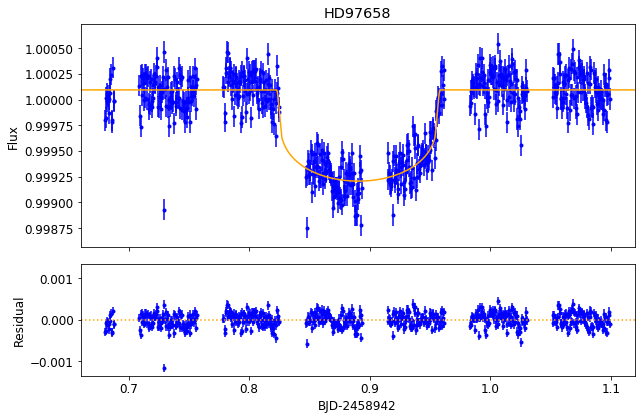

In [5]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12)
fig.savefig("HD97658_lmfit.eps")

### Sampling the posterior
Sampling the posterior probability distribution using the affine-invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/). 

*Using a lower number of burn-in and sampling steps here than would normally be used - just to see how it works*

The $\pm$1-sigma limits on parameters from the prior are indicated in the corner plot using dashed lines.

This return value from emcee_transit is an instance of an [EnsembleSampler](https://emcee.readthedocs.io/en/latest/user/sampler/) object.

In [6]:
sampler = dataset.emcee_sampler(burn=128, steps=64, nwalkers=64, thin=4)
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]

Running sampler ..



100%|██████████| 256/256 [01:07<00:00,  3.78it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 16384
    # data points      = 576
    # variables        = 8
    chi-square         = 1534.91704
    reduced chi-square = 2.70231873
    Akaike info crit   = -8354.32860
    Bayesian info crit = -8319.47974
[[Variables]]
    T_0:        0.89064887 +/- 4.9088e-04 (0.06%) (init = 0.89)
    P:          9.48926458 +/- 9.4981e-06 (0.00%) (init = 9.489264)
    D:          7.4590e-04 +/- 3.6614e-05 (4.91%) (init = 0.001244335)
    W:          0.01424188 +/- 1.3976e-04 (0.98%) (init = 0.02208278)
    b:          0.41457675 +/- 0.19196878 (46.30%) (init = 0.5)
    f_c:        0 (fixed)
    f_s:        0 (fixed)
    h_1:        0.70519251 +/- 0.01005260 (1.43%) (init = 0.708)
    h_2:        0.439 (fixed)
    c:          1.00009347 +/- 8.7677e-06 (0.00%) (init = 1)
    dfdx:       0 (fixed)
    dfdy:       0 (fixed)
    k:          0.02731115 +/- 0.00122728 (4.49%) == 'sqrt(D)'
    aR:         21.0079981 +/- 3.41079684 (

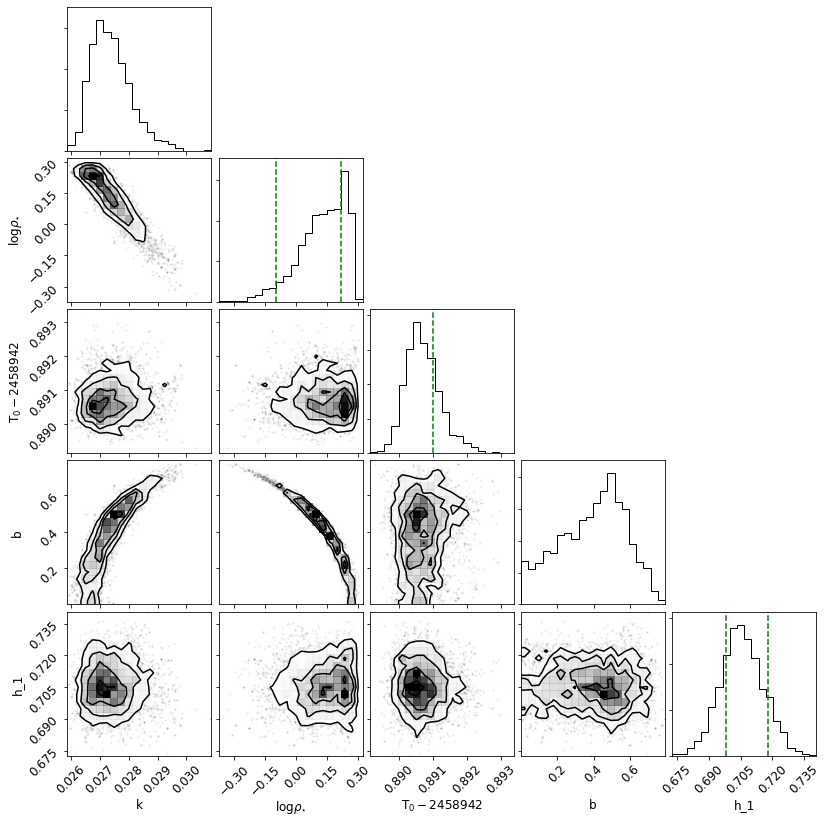

In [7]:
cornerplot = dataset.corner_plot(['k','logrho','T_0','b','h_1'])

#### Light curve fit with trends removed
Light curve fits for nsamples samples from the posterior are plotted together with the best-fit light curve model.

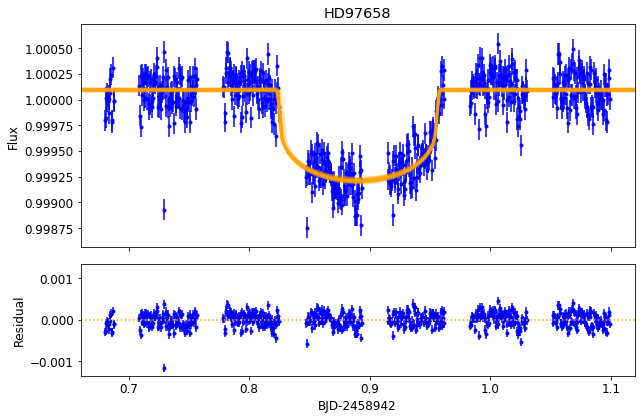

In [8]:
fig = dataset.plot_emcee(title=dataset.target,figsize=(9,6),fontsize=12, nsamples=100)

### Add correlated noise

Now use "add_shoterm=True" so that correlated noise is modelled using the SHOTerm kernel from [celerite](https://celerite.readthedocs.io/en/stable/). By default the parameter quality factor is fixed at $Q=1/\sqrt{2}$ so that the kernel is the one commonly used to model granulation noise
$$ k(\tau) = \omega_0 e^{-\omega_0\tau/\sqrt{2}}\cos\left(-\omega_0\tau/\sqrt{2} - \pi/4\right)$$

Bounds on log_sigma based on previous run to avoid tail of very low values that mess up the plots.

In [9]:
sampler = dataset.emcee_sampler(log_sigma=(-10.5,-7.5),
                                add_shoterm=True, burn=128, steps=64, nwalkers=64, thin=4)
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 128/128 [00:38<00:00,  3.32it/s]

Running sampler ..



100%|██████████| 256/256 [01:13<00:00,  3.46it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 16384
    # data points      = 576
    # variables        = 10
    chi-square         = 1617.90325
    reduced chi-square = 2.85848631
    Akaike info crit   = -8343.42277
    Bayesian info crit = -8299.86169
[[Variables]]
    T_0:         0.89035837 +/- 5.4900e-04 (0.06%) (init = 0.89)
    P:           9.48926137 +/- 1.1029e-05 (0.00%) (init = 9.489264)
    D:           7.4422e-04 +/- 7.8021e-05 (10.48%) (init = 0.001244335)
    W:           0.01432337 +/- 1.6886e-04 (1.18%) (init = 0.02208278)
    b:           0.44121427 +/- 0.22668891 (51.38%) (init = 0.5)
    f_c:         0 (fixed)
    f_s:         0 (fixed)
    h_1:         0.70610367 +/- 0.01071543 (1.52%) (init = 0.708)
    h_2:         0.439 (fixed)
    c:           1.00012440 +/- 5.8420e-05 (0.01%) (init = 1)
    dfdx:        0 (fixed)
    dfdy:        0 (fixed)
    k:           0.02728047 +/- 0.00122728 (4.50%) == 'sqrt(D)'
    aR:          20.6164819 

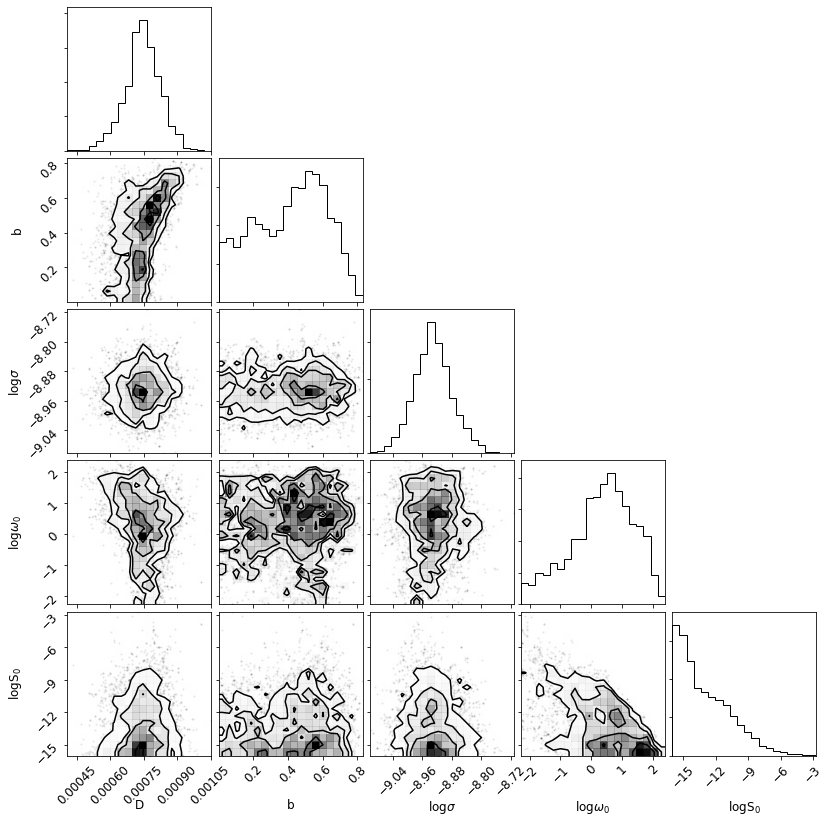

In [10]:
cornerplot = dataset.corner_plot(['D','b','log_sigma','log_omega0','log_S0'])

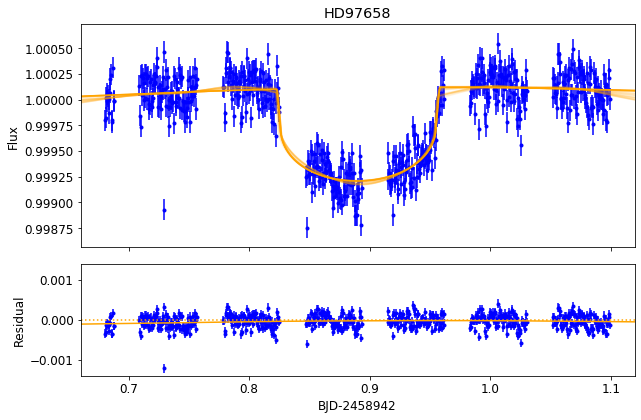

In [11]:
fig = dataset.plot_emcee(title=dataset.target,figsize=(9,6),fontsize=12)

(c) 2019 Pierre Maxted, Keele Univerity, UK